# Random Forest Regression

## 1. Veri Hazırlama ve Temizleme

Veriyi yüklüyoruz.
Eksik verileri temizliyoruz.
Gerekli dönüşümleri uyguluyoruz.

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Veri setini indir ve oku
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url, sheet_name="Online Retail")

# InvoiceDate'i datetime formatına çevir
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.index = df['InvoiceDate']

# Eksik verileri temizle (CustomerID olmayanları çıkar)
df = df.dropna(subset=["CustomerID"])

# Negatif veya sıfır Quantity ve UnitPrice değerlerini çıkar
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

## 2. Özellik (Feature) Mühendisliği

- Veri setindeki girdiler dakika bazinda. Bunlari günlük bazda grupluyoruz.
- Uzun vadeli trendler olup olmadigini kontrol etmek icin, Quantity ve UnitPrice degiskenlerini ayristiriyoruz.

             Quantity  UnitPrice  CustomerID
InvoiceDate                                 
2010-12-01      24215    6142.15  30440752.0
2010-12-02      31142    6395.85  32239487.0
2010-12-03      11839    3666.02  16874267.0
2010-12-04          0       0.00         0.0
2010-12-05      16449    7749.87  41161031.0


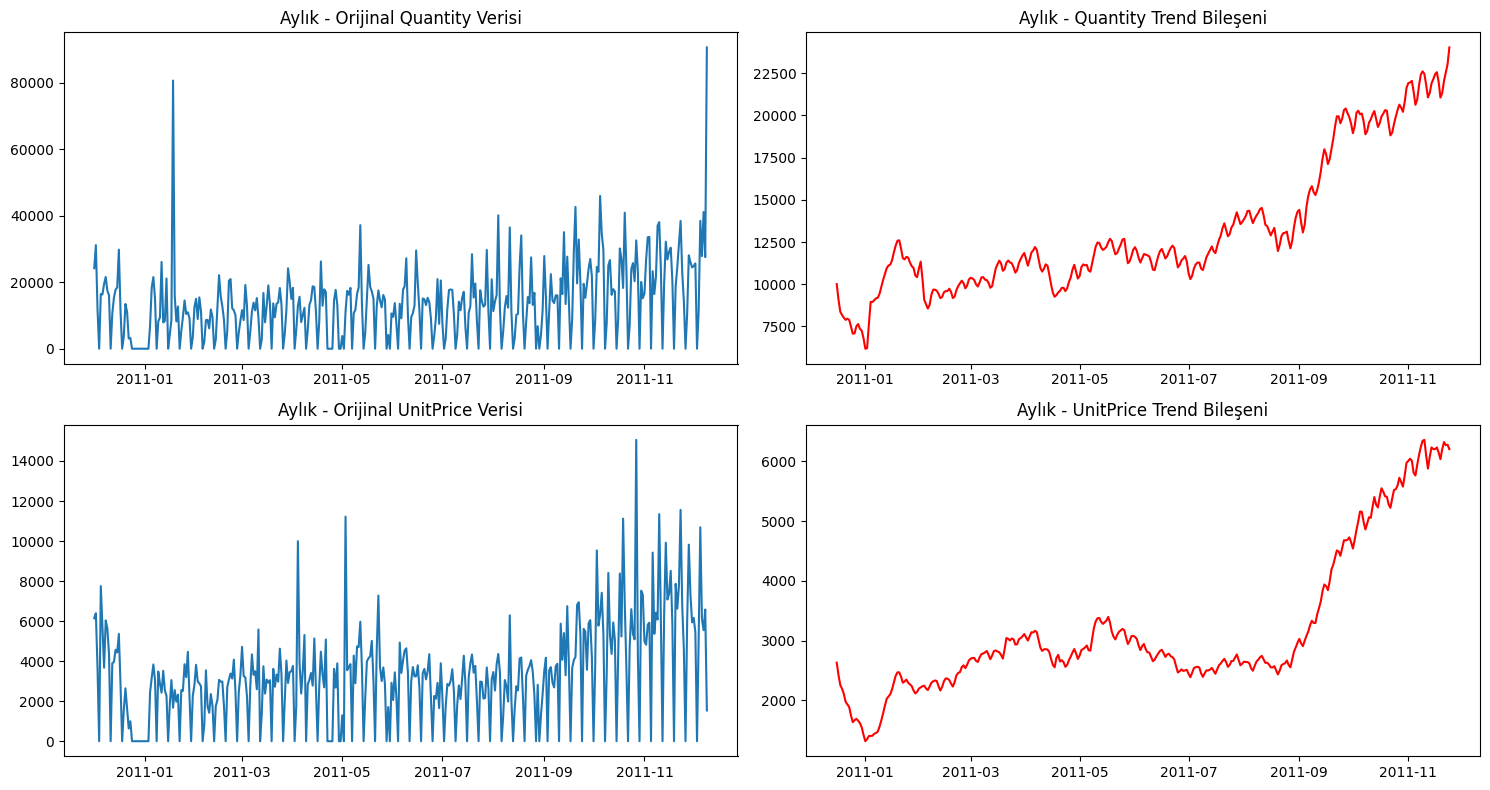

In [6]:
# Sadece sayısal (int veya float) sütunları seçerek günlük bazda gruplama yapalim
df_daily = df.select_dtypes(include=['number']).resample('D').sum()
df = df_daily
print(df.head())

# Quantity ve UnitPrice Döngüleri
decomp_monthly_quantity = seasonal_decompose(df["Quantity"], model="additive", period=30)
decomp_monthly_price = seasonal_decompose(df["UnitPrice"], model="additive", period=30)

# Grafikleri çizme
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Aylik Quantity decomposition çizimleri
axes[0, 0].plot(decomp_monthly_quantity.observed, label="Orijinal Quantity Verisi")
axes[0, 0].set_title("Aylık - Orijinal Quantity Verisi")
axes[0, 1].plot(decomp_monthly_quantity.trend, label="Trend Bileşeni", color="red")
axes[0, 1].set_title("Aylık - Quantity Trend Bileşeni")

# Aylik UnitPrice decomposition çizimleri
axes[1, 0].plot(decomp_monthly_price.observed, label="Orijinal UnitPrice Verisi")
axes[1, 0].set_title("Aylık - Orijinal UnitPrice Verisi")
axes[1, 1].plot(decomp_monthly_price.trend, label="Trend Bileşeni", color="red")
axes[1, 1].set_title("Aylık - UnitPrice Trend Bileşeni")

plt.tight_layout()
plt.show()

# Miktar (Quantity) için ayrıştırma ve Nan degerlerini doldurma
df["Quantity_Trend"] = decomp_monthly_quantity.trend
df["Quantity_Trend"].fillna(df["Quantity_Trend"].mean(), inplace=True)
df.reset_index(inplace=True)
df["Month"] = df["InvoiceDate"].dt.month
df["WeekOfYear"] = df["InvoiceDate"].dt.isocalendar().week

# Kullanılacak özellikler
features = [
    "UnitPrice",
    "Month",
    "WeekOfYear",
]
target = "Quantity_Trend"

X = df[features]
y = df[target]

# Eğitim & test kümelerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 3. Model Eğitimi

- Random Forest Regressor modelini eğitiyoruz.
- n_estimators = 100 olarak ayarlıyoruz.

In [7]:
# Random Forest Modeli (n_estimators=100)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 4. Model Değerlendirme ve Sonuçlar

- RMSE’yi hesaplıyoruz ve baz model ile karşılaştırıyoruz.
- Gerçek vs. Tahmin edilen değerleri görselleştiriyoruz.

Optimized Model RMSE: 1195.52
Baseline RMSE: 3742.99
Modelimiz, rastgele bir ortalama tahmininden çok daha iyi performans gösteriyor.


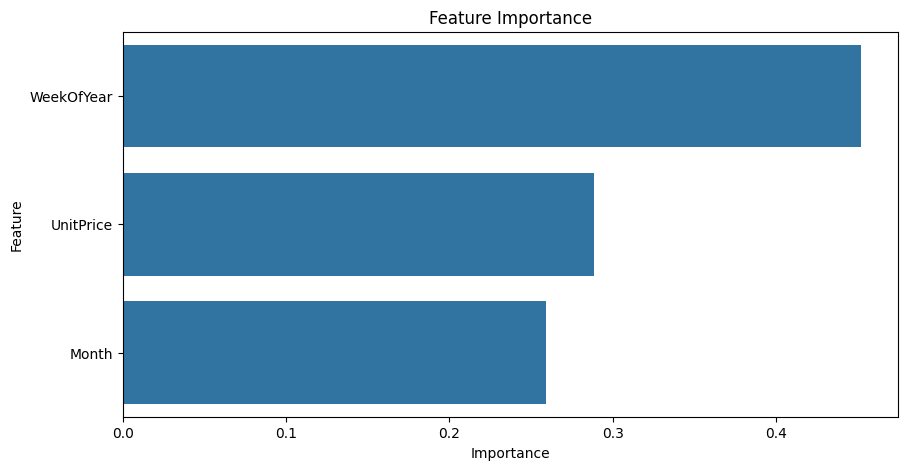

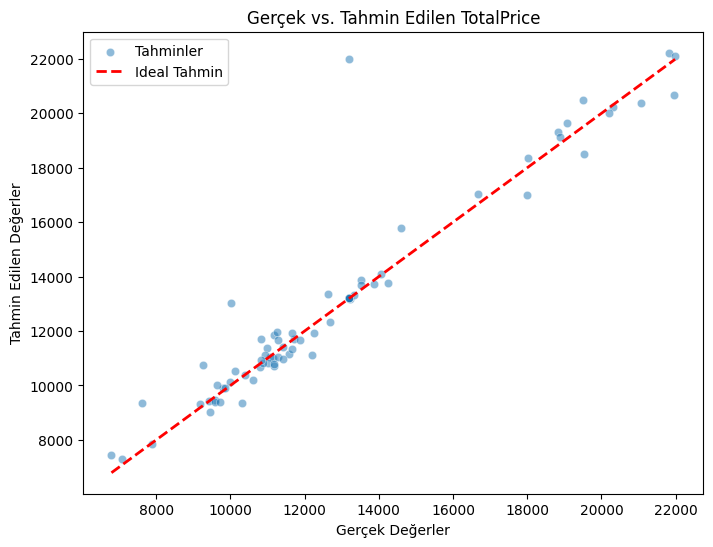

In [8]:
# Tahmin yap
y_pred = rf.predict(X_test)

# RMSE hesapla
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Baseline Model: Ortalama tahmin
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# Sonuçları yazdır
print(f"Optimized Model RMSE: {rmse:.2f}")
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print("Modelimiz, rastgele bir ortalama tahmininden çok daha iyi performans gösteriyor.")

# Özellik Önem Düzeyleri
feature_importances = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Feature Importance")
plt.show()

# Gerçek vs. Tahmin edilen görselleştirme
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, label="Tahminler")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Tahmin")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Gerçek vs. Tahmin Edilen TotalPrice")
plt.legend()
plt.show()